In [48]:
# %load ./dsfs/probs.py
from typing import Tuple
import math
import random
from collections import Counter
import matplotlib.pyplot as plt

def uniform_pdf(x: float) -> float:
    return 1 if 0 <= x < 1 else 0

def uniform_cdf(x: float) -> float:
    if x < 0 : return 0
    if x < 1 : return x
    return 1

def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (math.exp(-(x-mu)**2 / 2 / sigma **2) / (math.sqrt(2 * math.pi) * sigma))


def normal_cdf(x: float, mu:float = 0, sigma: float =1) -> float:
    return (1 + math.erf((x-mu)/ math.sqrt(2) / sigma)) /2


def inverse_normal_cdf(p: float, mu: float = 0, sigma: float = 1, tolerance: float = 0.00001) -> float:
    if mu != 0 or sigma != 1: return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0
    hi_z = 10
    while (hi_z - low_z) > tolerance:
        mid_z = (low_z + hi_z) /2
        mid_p = normal_cdf(mid_z)
        if mid_p < p:
            low_z = mid_z
        else:
            hi_z = mid_z
    return mid_z


def bernouilli_trial(p: float) -> int:
    return 1 if random.random() < p else 0


def binomial(n: int, p: float) -> int:
    return sum(bernouilli_trial(p)for _ in range(n))


def binomial_histogram(p: float, n: int, num_points: int) -> None:
    data = [binomial(n, p) for _ in range(num_points)]
    histogram = Counter(data)
    plt.bar(
        [ x - 0.5 for x in histogram.keys()],
        [v/num_points for v in histogram.values()],
        0.8,
        color='0.75'
    )
    mu, sigma = normal_approximation_to_binomial(n, p)

    xs = range(min(data), max(data) + 1)
    ys = [normal_cdf(i + 0.5, mu, sigma) - normal_cdf(i - 0.5, mu, sigma) for i in xs]
    plt.plot(xs, ys)
    plt.title('Binomal Distribution vs Normal Approximation')
    plt.show()


def normal_approximation_to_binomial(n: int, p:float) -> Tuple[float, float]:
    mu = n * p
    sigma = math.sqrt(mu * (1-p))
    return mu, sigma



normal_probability_below = normal_cdf

def normal_probability_above(lo: float, mu: float = 0, sigma: float = 1) -> float:
    return 1 - normal_probability_below(lo, mu, sigma)


def normal_probability_between(lo: float, hi: float, mu: float = 0, sigma: float = 1) -> float:
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)


def normal_probability_outside(lo, float, hi: float, mu: float = 0, sigma: float = 1 ) -> float:
    return 1 - normal_probability_between(lo, hi, mu, sigma)


def normal_upper_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    return inverse_normal_cdf(probability, mu, sigma)


def normal_lower_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    return inverse_normal_cdf(1-probability, mu, sigma)


def normal_two_sided_bounds(probability: float, mu: float = 0, sigma: float = 1) -> Tuple[float, float]:
    tail_probability = (1-probability) / 2
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound


def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    if x >= mu:
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        return 2 * normal_probability_below(x, mu, sigma)


upper_p_value = normal_probability_above

lower_p_value = normal_probability_below



def B(alpha: float, beta: float) -> float:
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x: float, alpha: float, beta: float) -> float:
    if x <= 0 or x >= 1:
        return 0
    return x ** (alpha -1) * (1 -x) ** (beta -1) / B(alpha, beta)



In [49]:
# Flip 1000 coins
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
display(mu_0, sigma_0)
lower_bound, upper_bound = normal_two_sided_bounds(0.95, mu_0, sigma_0)
display(lower_bound, upper_bound)
display("This meams that there is only a 5% chance that we observe a result outside of those bounds (469-530)")

500.0

15.811388300841896

469.01026640487555

530.9897335951244

'This meams that there is only a 5% chance that we observe a result outside of those bounds (469-530)'

In [50]:
# A slightly bias coin
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
#Type 2 is a false negative
type_2_probability = normal_probability_between(lo=lower_bound, hi=upper_bound, mu=mu_1, sigma=sigma_1)
power = 1 - type_2_probability
display(power)

0.8865480012953671

In [51]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
assert hi >526 and hi < 527, hi
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability
display(power)

0.9363794803307173

In [52]:
two_sided_p_value(529.5, mu_0, sigma_0)  # If the coin is fair, we have a 6% chance of flipping 530 heads

0.06207721579598835

In [53]:
# Simulation
extreme_value_count = 0
for _ in range(1000):
    num_heads = binomial(1000, 0.5)
    if num_heads >= 530 or num_heads <= 470:
        extreme_value_count += 1
#p-value if 0.062 -> ~62  extreme value for 1000 trial
assert 59 < extreme_value_count < 65, f"{extreme_value_count}"

AssertionError: 57

In [54]:
#Confidence Interval
p_hat = 525/1000 # we don't know the probability and we observed 525 head coins
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat)/1000) 
lo, hi = normal_two_sided_bounds(0.95, mu, sigma)
display(lo, hi)
assert lo <= 0.5 <= hi #We cannot say the coin is unfair (we are 95% confident)

p_hat = 540/1000 # We observe 540 head coins
mu = p_hat
sigma = math.sqrt(p_hat * (1-p_hat)/1000)
lo, hi = normal_two_sided_bounds(0.95, mu, sigma)
display(lo, hi)
assert 0.5 <= lo #We cay say the coin is unfair (we are 95% confident)

0.4940490278129096

0.5559509721870904

0.5091095927295919

0.5708904072704082

In [55]:
# p-hacking

from typing import List

def reject_fairness(num_heads: int) -> bool:
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [binomial(1000, 0.5) for _ in range(1000)]

num_rejections = len([experiment for experiment in experiments if reject_fairness(experiment)])

assert num_rejections == 46, num_rejections  #i.e if we try often enough we will find experiments that reject our Hypothese


In [56]:
# A-B Testing
# N_a people sees ad A and n_a click it. n_a/Na => p_a (probability of someone click on ad A)


def estimated_parameters(N: int, n: int) -> Tuple[float, float]:
    p = n/N
    sigma = math.sqrt(p * (1 -p) / N)
    return p, sigma

def a_b_test_statistic(N_a: int, n_a: int, N_b: int, n_b: int) -> float:
    p_a, sigma_a = estimated_parameters(N_a, n_a)
    p_b, sigma_b = estimated_parameters(N_b, n_b)
    return (p_b - p_a)/ math.sqrt(sigma_a**2 + sigma_b**2)

z1 = a_b_test_statistic(1000, 200, 1000, 180)
display(z1)
display(two_sided_p_value(z1)) 

z2 = a_b_test_statistic(1000, 200, 1000, 150)
display(two_sided_p_value(z2))



-1.1403464899034472

0.254141976542236

0.003189699706216853

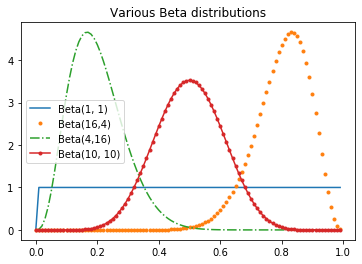

In [74]:
xs = [x/100 for x in range(0, 100)]
plt.plot(xs, [beta_pdf(x, 1, 1) for x in xs], '-', label='Beta(1, 1)')
plt.plot(xs, [beta_pdf(x, 16, 4) for x in xs], '.', label='Beta(16,4)')
plt.plot(xs, [beta_pdf(x, 4, 16) for x in xs],  '-.', label='Beta(4,16)')
plt.plot(xs, [beta_pdf(x, 10, 10) for x in xs], '.-', label='Beta(10, 10)')
plt.legend()
plt.title('Various Beta distributions')
plt.show()

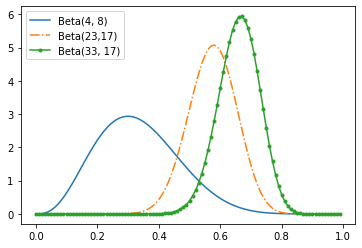

In [76]:
# Coin fairness example
# you flip 10 coins, see 3 heads
# If you started with a B(1, 1) which means you don't have an opinion about the fairness of the coin, 
# you would have a new distribution of B(1+3, 1+7) => B(4, 8) which is centered at 0.33. Roughly the observed probability.
# If you started with a B(20, 20), you would have B(23, 27) which is centered at 0.46 slightly revising belief that
# the coin is slightly biased towards tails
# If you strted at B(30, 10), believing the coin is biased towards heads, the new distribution would be B(33, 17)
# You would still believe a head bias but less strongly.

xs = [x/100 for x in range(0, 100)]
plt.plot(xs, [beta_pdf(x, 4, 8) for x in xs], '-', label='Beta(4, 8)')
plt.plot(xs, [beta_pdf(x, 23, 17) for x in xs],  '-.', label='Beta(23,17)')
plt.plot(xs, [beta_pdf(x, 33, 17) for x in xs], '.-', label='Beta(33, 17)')
plt.legend()
plt.show()
